In [50]:
import os, random, time, math
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import timm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Device: cuda
GPU: NVIDIA GeForce RTX 4060 Ti


In [52]:
CFG = {
    "seed": 42,
    "data_dir": r"F:\Datasets\AlzheimerDataset\Dataset",  
    "img_size": 300,                  
    "batch_size": 32,                 
    "epochs": 100,
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "num_workers": 2,
    "model_name": "efficientnet_b3",  
    "pretrained": True,
    "dropout": 0.2,
    "val_ratio": 0.15,
    "test_ratio": 0.15,
    "use_amp": True,
    "out_dir": "outputs"
}

In [53]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

set_seed(CFG["seed"])
os.makedirs(CFG["out_dir"], exist_ok=True)

In [54]:
train_tfms = transforms.Compose([
    transforms.Resize((CFG["img_size"], CFG["img_size"])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((CFG["img_size"], CFG["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

In [55]:
# base dataset without transforms (for splitting)
base_ds = datasets.ImageFolder(CFG["data_dir"])
class_names = base_ds.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Total images:", len(base_ds))

Classes: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
Total images: 6400


In [56]:
targets = np.array(base_ds.targets)
idx = np.arange(len(targets))

val_ratio = CFG["val_ratio"]
test_ratio = CFG["test_ratio"]
temp_ratio = val_ratio + test_ratio

# Train vs Temp
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=temp_ratio, random_state=CFG["seed"])
train_idx, temp_idx = next(sss1.split(idx, targets))

# Val vs Test from Temp
temp_targets = targets[temp_idx]
test_size = test_ratio / temp_ratio
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=CFG["seed"])
val_rel, test_rel = next(sss2.split(np.arange(len(temp_idx)), temp_targets))

val_idx = temp_idx[val_rel]
test_idx = temp_idx[test_rel]

print("Train:", len(train_idx), "Val:", len(val_idx), "Test:", len(test_idx))

Train: 4480 Val: 960 Test: 960


In [57]:
train_full = datasets.ImageFolder(CFG["data_dir"], transform=train_tfms)
eval_full  = datasets.ImageFolder(CFG["data_dir"], transform=eval_tfms)

train_ds = Subset(train_full, train_idx)
val_ds   = Subset(eval_full,  val_idx)
test_ds  = Subset(eval_full,  test_idx)

train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True,
                          num_workers=CFG["num_workers"], pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False,
                          num_workers=CFG["num_workers"], pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=CFG["batch_size"], shuffle=False,
                          num_workers=CFG["num_workers"], pin_memory=True)

In [58]:
train_targets = targets[train_idx]
counts = np.bincount(train_targets, minlength=num_classes)
print("Class counts:", dict(zip(class_names, counts)))

weights = (counts.sum() / (counts + 1e-6))
weights = weights / weights.mean()
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)
print("Class weights:", class_weights)

Class counts: {'Mild_Demented': 627, 'Moderate_Demented': 45, 'Non_Demented': 2240, 'Very_Mild_Demented': 1568}
Class weights: tensor([0.2562, 3.5696, 0.0717, 0.1024], device='cuda:0')


In [59]:
model = timm.create_model(
    CFG["model_name"],
    pretrained=CFG["pretrained"],
    num_classes=num_classes,
    drop_rate=CFG["dropout"]
).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])
scaler = torch.cuda.amp.GradScaler(enabled=(CFG["use_amp"] and device.type=="cuda"))

print("Model:", CFG["model_name"])

Model: efficientnet_b3


C:\Users\User\AppData\Local\Temp\ipykernel_34600\3715062344.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(CFG["use_amp"] and device.type=="cuda"))


In [60]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    losses = []
    all_preds = []
    all_true = []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        losses.append(loss.item())

        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu())
        all_true.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_true = torch.cat(all_true).numpy()
    acc = (all_preds == all_true).mean()

    return float(np.mean(losses)), float(acc), all_preds, all_true


def train_one_epoch(model, loader):
    model.train()
    losses = []

    pbar = tqdm(loader, leave=False)
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(CFG["use_amp"] and device.type=="cuda")):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())
        pbar.set_postfix(train_loss=float(np.mean(losses)))

    return float(np.mean(losses))

Epoch 100/100 | train_loss=0.0160 | val_loss=0.0175 | val_acc=0.9927 | 44.8s


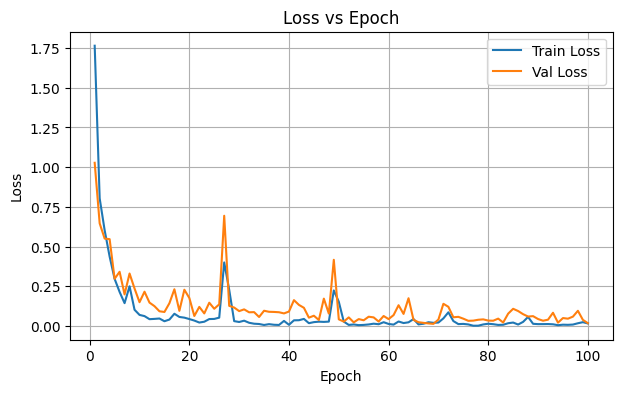

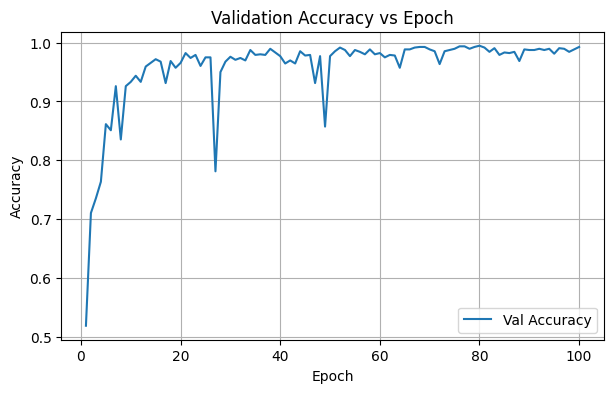

In [61]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

best_val_acc = -1
best_path = os.path.join(CFG["out_dir"], "best_efficientnet.pt")

train_loss_hist = []
val_loss_hist = []
val_acc_hist  = []

for epoch in range(1, CFG["epochs"] + 1):
    t0 = time.time()

    train_loss = train_one_epoch(model, train_loader)
    val_loss, val_acc, _, _ = evaluate(model, val_loader)

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    dt = time.time() - t0

    # Clear previous output to create "live" graph effect
    clear_output(wait=True)

    # --------- PRINT STATUS ----------
    print(f"Epoch {epoch}/{CFG['epochs']} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f} | {dt:.1f}s")

    # --------- PLOT GRAPHS ----------
    # Loss curve
    plt.figure(figsize=(7,4))
    plt.plot(range(1, len(train_loss_hist)+1), train_loss_hist, label="Train Loss")
    plt.plot(range(1, len(val_loss_hist)+1), val_loss_hist, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy curve
    plt.figure(figsize=(7,4))
    plt.plot(range(1, len(val_acc_hist)+1), val_acc_hist, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy vs Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --------- SAVE BEST ----------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "model_state": model.state_dict(),
            "class_names": class_names,
            "model_name": CFG["model_name"],
            "img_size": CFG["img_size"]
        }, best_path)
        print(f"Best model: {best_path} (val_acc={best_val_acc:.4f})")

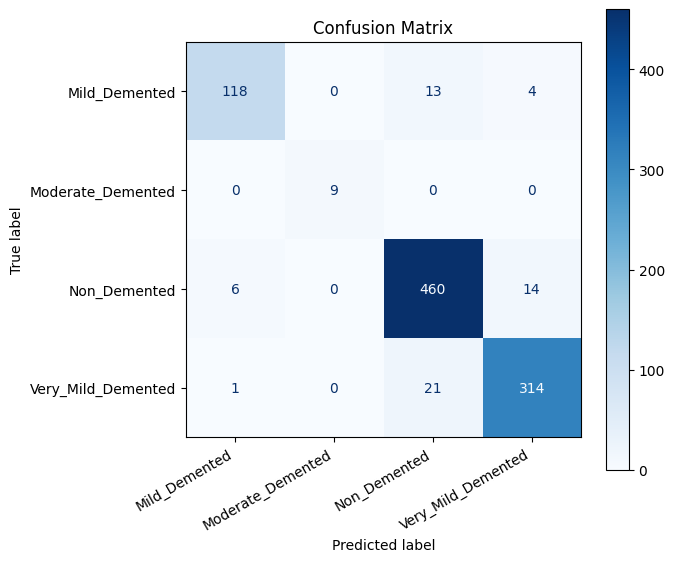

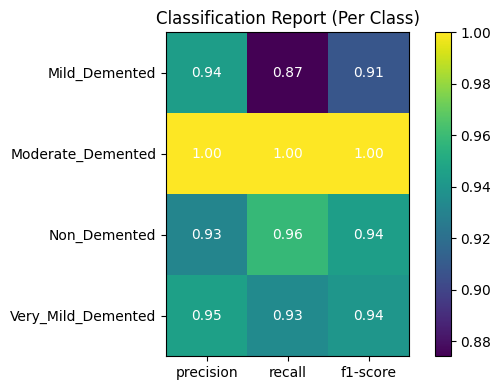

In [64]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# =========================
# 1️⃣ CONFUSION MATRIX
# =========================
cm = confusion_matrix(y_true, preds)

plt.figure(figsize=(7,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=plt.gca(), colorbar=True)
plt.title("Confusion Matrix")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


# =========================
# 2️⃣ CLASSIFICATION REPORT HEATMAP
# =========================
report = classification_report(
    y_true,
    preds,
    target_names=class_names,
    output_dict=True
)

metrics = ["precision", "recall", "f1-score"]
data = np.array([[report[c][m] for m in metrics] for c in class_names])

plt.figure(figsize=(7,4))
im = plt.imshow(data, cmap="viridis")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(np.arange(len(metrics)), metrics)
plt.yticks(np.arange(len(class_names)), class_names)
plt.title("Classification Report (Per Class)")
plt.tight_layout()

for i in range(len(class_names)):
    for j in range(len(metrics)):
        plt.text(j, i, f"{data[i, j]:.2f}",
                 ha="center", va="center", color="white")

plt.show()




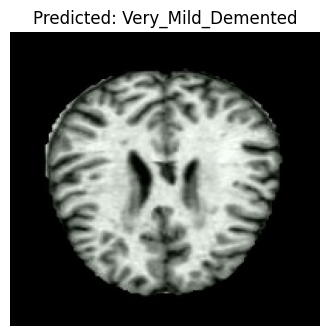

Prediction probabilities:
Mild_Demented       : 0.0000
Moderate_Demented   : 0.0002
Non_Demented        : 0.0029
Very_Mild_Demented  : 0.9969
Very_Mild_Demented [1.8380183e-08 2.1984401e-04 2.9034386e-03 9.9687672e-01]


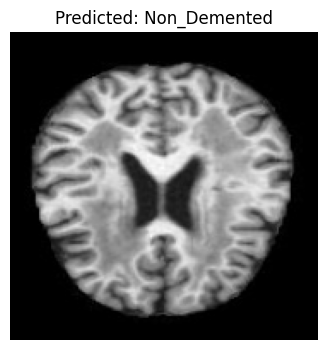

Prediction probabilities:
Mild_Demented       : 0.0000
Moderate_Demented   : 0.0000
Non_Demented        : 1.0000
Very_Mild_Demented  : 0.0000
Non_Demented [3.2685701e-23 6.0319343e-26 1.0000000e+00 1.5545819e-25]


In [63]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

def predict_and_show(img_path):
    tfm = eval_tfms

    # Load image
    img = Image.open(img_path).convert("RGB")
    x = tfm(img).unsqueeze(0).to(device)

    # Prediction
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()
        pred_idx = int(np.argmax(probs))

    predicted_label = class_names[pred_idx]

    # ---- DISPLAY IMAGE ----
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label}", fontsize=12)
    plt.show()

    # ---- PRINT PROBABILITIES ----
    print("Prediction probabilities:")
    for i, cls in enumerate(class_names):
        print(f"{cls:20s}: {probs[i]:.4f}")

    return predicted_label, probs


label, probs = predict_and_show(r"F:\Datasets\AlzheimerDataset\Dataset\Very_Mild_Demented_Sample.jpg")
print(label, probs)


label, probs = predict_and_show(r"F:\Datasets\AlzheimerDataset\Dataset\Non_Demented_Sample.jpg")
print(label, probs)




